<a href="https://colab.research.google.com/github/anh1811/imageprocessing/blob/master/Object_Regcognition_using_BoW_(final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from scipy.cluster.vq import *
import tensorflow_datasets as tfds
import sklearn
import pandas as pd
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

In [ ]:
#run this if you're new
!pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


#Dataset



Dataset toàn ảnh -> SIFT (bộ tách đặc trưng) SURF -> keypoints ---> BOW (FLann / K-means tree, SIFT), độ lớn của từ điển ---> tạo các vector có độ dài N-clusster -> Thuật toán phân loại (KNN, Vector support machine, ..) -> hyperparameters để lựa chọn -> K_fold crossvalidation -> kết quả ảnh đấy chứa object gì 

Dataset sử dụng là coil100: 7200 tấm ảnh và 100 object

In [ ]:
# một dataset lưu dưới dạng dictionary gồm các trường 'image', 'label'
#tfds -> tensorflow dataset
dataset = tfds.load(name = 'coil100')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/coil100/1.0.0.incompleteJ0F6KF/coil100-train.tfrecord


  0%|          | 0/7200 [00:00<?, ? examples/s]

Dataset coil100 downloaded and prepared to /root/tensorflow_datasets/coil100/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# shuffle dữ liệu 1000 lần
#các dữ liệu dược lưu dưới dạng dạng tf. tensor của tensorflow --> chuyển đổi sang numpy
#shuffle dataset
ds = dataset["train"].shuffle(1000).prefetch(1)
x_train, y_train = [], []
#tập huấn luyện 
for item in ds:
  x_train.append(item["image"].numpy())
  y_train.append(int(item["object_id"].numpy().decode("utf-8")[3:]) -1)

In [ ]:
# 1500 dữ liệu test/ 5700 dữ liệu train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Bag of Words 


    keypoints The detected keypoints. A 1-by-N structure array with the following fields:
        pt coordinates of the keypoint [x,y]
        size diameter of the meaningful keypoint neighborhood
        angle computed orientation of the keypoint (-1 if not applicable); it's in [0,360) degrees and measured relative to image coordinate system (y-axis is directed downward), i.e in clockwise.
        response the response by which the most strong keypoints have been selected. Can be used for further sorting or subsampling.
        octave octave (pyramid layer) from which the keypoint has been extracted.
        class_id object class (if the keypoints need to be clustered by an object they belong to).

In [ ]:
def create_gray_dataset(X,y):
  x_gray = list()
  y_gray = list()
  sift = cv2.SIFT_create()
  kps, des_set = [], []
  for i, img in enumerate(X):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    key, des = sift.detectAndCompute(img, None) 
    if des is not None:
      x_gray.append(img)
      y_gray.append(y[i])
      kps.append(key)
      des_set.extend(np.array(des))
  return np.array(x_gray), np.array(y_gray).reshape(-1), kps, np.array(des_set)

In [ ]:
x_gray_train, y_gray_train, kps, descriptors = create_gray_dataset(x_train,y_train)
x_gray_test, y_gray_test, kps_test, des_set_test = create_gray_dataset(x_test, y_test)
# x_gray_train = set(x_gray_train)

60

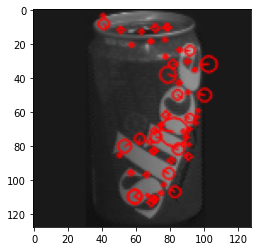

In [ ]:
# sift = cv2.SIFT_create()
# img = cv2.cvtColor(x_train[0], cv2.COLOR_BGR2GRAY)
# key, des = sift.detectAndCompute(img, None)
# output_image = cv2.drawKeypoints(img, key, 0, (255, 0, 0),
#                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# plt.imshow(output_image)
# len(key)

In [ ]:
descriptors.shape

(219934, 128)

In [ ]:
flann_params = dict(algorithm = 1, trees = 5)
flann =cv2.FlannBasedMatcher(flann_params, {})

sift = cv2.SIFT_create()

In [ ]:
def create_BOW(sift, flann):
  bow_kmeans_trainer = cv2.BOWKMeansTrainer(600) 
  extract_bow = cv2.BOWImgDescriptorExtractor(sift, flann) 
  vocab = bow_kmeans_trainer.cluster(descriptors)
  extract_bow.setVocabulary(vocab)
  return extract_bow

extract_bow = create_BOW(sift,flann)

In [ ]:
# tạo bộ dữ liệu với extrac_bow -> descriptor cho mỗi ảnh 
# x_train -> giá trị pixel của mỗi ảnh -> thành vector 400 từ bow
def create_traindata(extract_bow, x_gray_train, kps, tf_idf = True):
  traindata, trainlabels = [], []
  for i in range(len(x_gray_train)):
    traindata.append(extract_bow.compute(x_gray_train[i], kps[i]).reshape([-1]))
  traindata = np.array(traindata)
  if tf_idf:
    nbr_occurences = np.sum( (traindata > 0) * 1, axis = 0)
    idf = np.array(np.log10((1.0*len(x_gray_train)+1) / (1.0*nbr_occurences + 1)), 'float32')
    return traindata * idf, idf
  else: return traindata, 1

In [ ]:
traindata, idf  = create_traindata(extract_bow, x_gray_train, kps, tf_idf = True)

In [ ]:
svm_clf = SVC(C=8.638787150282738, gamma= 7.875101714101604)
svm_clf.fit(np.array(traindata), y_gray_train)

SVC(C=8.638787150282738, gamma=7.875101714101604)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(1,40), "C": uniform(0, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=30, verbose=2, cv=10)
rnd_search_cv.fit(traindata[:1000], y_gray_train[:1000])

In [ ]:
rnd_search_cv.best_score_

0.766

In [ ]:
rnd_search_cv.best_estimator_.fit(np.array(traindata), np.array(y_gray_train).reshape(-1))

SVC(C=8.638787150282738, gamma=7.875101714101604)

In [ ]:
def predict(fn, extract_bow, key):  
  f = extract_bow.compute(fn, key) * idf  
  if f is not None:
    # p = rnd_search_cv.best_estimator_.predict(f)
    p = svm_clf.predict(f)
  else:
    return None  
  return p

In [ ]:
def accuracy(x_gray_test, y_gray_test, kps_test):
  y_pred = []
  for i in range(len(x_gray_test)):
    y_pred.append(predict(x_gray_test[i], extract_bow, kps_test))
  accuracy_score(y_gray_test, np.array(y_pred).reshape(-1))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print()
# Print classification_report:
print('Classification_report:')
print(classification_report(y_gray_test, y_pred))

# ConfusionMatrixDisplay.from_predictions(np.array(y_gray_test).reshape(-1), np.array(y_pred).reshape(-1))
# plt.show()

In [ ]:
import time
from sklearn.model_selection import KFold
def train(x_gray_train, y_gray_train, dic_size, cross_validation):
  
  bow_kmeans_trainer = cv2.BOWKMeansTrainer(dic_size)
  extract_bow = cv2.BOWImgDescriptorExtractor(sift, flann)
  
  #bắt đầu tạo từ điển bằng phuowgn pháp k-means
  start_time = time.time()
  vocab = bow_kmeans_trainer.cluster(descriptors)
  time_run = time.time() - start_time 
  
  # đưa từ điền vào trong bow_kmeans_trainer
  extract_bow.setVocabulary(vocab)
  
  traindata = []
  for i in range(len(x_gray_train)):
    traindata.append(extract_bow.compute(x_gray_train[i], kps[i]).reshape([-1]))
  traindata = np.array(traindata)
  if cross_validation:
    kf = KFold(n_splits=4)
    kf.get_n_splits(traindata)

    acc_per_fold = list()
    for train_index, test_index in kf.split(traindata):
      X_train, X_test = traindata[train_index], traindata[test_index]
      y_train, y_test = np.array(y_gray_train).reshape(-1)[train_index], np.array(y_gray_train).reshape(-1)[test_index]
      
      svm_clf = SVC(C=8.638787150282738, gamma=7.875101714101604)
      svm_clf.fit(np.array(X_train), y_train)
      y_pred = []
      for i in range(len(y_test)):
        y_pred.append(svm_clf.predict(X_test[i][np.newaxis,:]))
      acc_per_fold.append(accuracy_score(np.array(y_test), np.array(y_pred).reshape(-1)))
    
    return time_run, sum(acc_per_fold)/len(acc_per_fold)
  else: 
    y_pred = []
    for i in range(len(x_gray_test)):
        y_pred.append(predict(x_gray_test[i]))
    return accuracy_score(np.array(y_gray_test).reshape(-1), np.array(y_pred).reshape(-1))

k_list = [600,650,700]
# k_list = [100,150]
time_list = []
acc_list = []
for k in k_list:
  time_run, acc =  train(k, True)
  time_list.append(time_run)
  acc_list.append(acc)


In [ ]:
print(time_list)
print(acc_list)

[750.2964181900024, 837.3154561519623, 929.511946439743, 1017.1361055374146, 1107.3100645542145]
[0.9484114429331757, 0.9577106741573034, 0.9543763552138774, 0.9522712152572442, 0.9591133205204021]


In [ ]:
print(time_list)
print(acc_list)

[1162.5634388923645, 1173.8125321865082, 1263.8604974746704]
[0.9570084269662921, 0.9587633057362508, 0.9577103045535187]


In [ ]:
time_list = [750.2964181900024, 837.3154561519623, 929.511946439743, 1017.1361055374146, 1162.5634388923645, 1173.8125321865082, 1263.8604974746704]
k_list = [400,450,500,550,600,650,700]
acc_list = [0.9484114429331757, 0.9577106741573034, 0.9543763552138774, 0.9522712152572442, 0.9591133205204021, 0.9587633057362508, 0.9577103045535187]

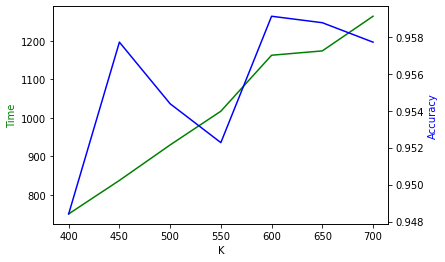

<Figure size 1440x720 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.figure(figsize=(20, 10))
ax2 = ax1.twinx()
ax1.plot(k_list, time_list, 'g-')
ax2.plot(k_list, acc_list,  '-b')

ax1.set_xlabel('K')
ax1.set_ylabel('Time', color='g')
ax2.set_ylabel('Accuracy', color='b')

plt.show()


In [ ]:
label = "{0}".format(y_train[0])
img = cv2.putText(x_train[0], label, (0, 0),  cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 2)
plt.imshow()